In [1]:
from pyspark import SparkContext, SparkConf 
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
# from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType, Row
import pyspark.sql.functions as F

In [2]:
spark = SparkSession.builder.appName('laba 2 KR').config("spark.jars.packages", "com.databricks:spark-xml_2.12:0.17.0").getOrCreate()

In [5]:
df = spark.read.format("com.databricks.spark.xml").option("rootTag", "hierarchy").option("rowTag", "row").load("posts_sample.xml")
df.head()

Row(_AcceptedAnswerId=7, _AnswerCount=13, _Body="<p>I want to use a track-bar to change a form's opacity.</p>\n\n<p>This is my code:</p>\n\n<pre><code>decimal trans = trackBar1.Value / 5000;\nthis.Opacity = trans;\n</code></pre>\n\n<p>When I build the application, it gives the following error:</p>\n\n<blockquote>\n  <p>Cannot implicitly convert type <code>'decimal'</code> to <code>'double'</code></p>\n</blockquote>\n\n<p>I tried using <code>trans</code> and <code>double</code> but then the control doesn't work. This code worked fine in a past VB.NET project.</p>\n", _ClosedDate=None, _CommentCount=2, _CommunityOwnedDate=datetime.datetime(2012, 10, 31, 20, 42, 47, 213000), _CreationDate=datetime.datetime(2008, 8, 1, 2, 42, 52, 667000), _FavoriteCount=48, _Id=4, _LastActivityDate=datetime.datetime(2019, 7, 19, 5, 39, 54, 173000), _LastEditDate=datetime.datetime(2019, 7, 19, 5, 39, 54, 173000), _LastEditorDisplayName='Rich B', _LastEditorUserId=3641067, _OwnerDisplayName=None, _OwnerUserI

In [6]:
df.schema.names

['_AcceptedAnswerId',
 '_AnswerCount',
 '_Body',
 '_ClosedDate',
 '_CommentCount',
 '_CommunityOwnedDate',
 '_CreationDate',
 '_FavoriteCount',
 '_Id',
 '_LastActivityDate',
 '_LastEditDate',
 '_LastEditorDisplayName',
 '_LastEditorUserId',
 '_OwnerDisplayName',
 '_OwnerUserId',
 '_ParentId',
 '_PostTypeId',
 '_Score',
 '_Tags',
 '_Title',
 '_ViewCount']

In [7]:
df = df.drop('_Body', '_ClosedDate',  '_CommentCount', '_CommunityOwnedDate', '_LastEditDate', '_AcceptedAnswerId',
 '_LastEditorDisplayName',
 '_LastEditorUserId',
 '_OwnerDisplayName',
 '_OwnerUserId', '_ParentId',  '_PostTypeId', '_Id', '_ViewCount', '_FavoriteCount', '_AnswerCount', '_Title')
df = df.dropna(subset=["_Tags", "_CreationDate", "_Score"])

In [8]:
df.show()

+--------------------+--------------------+------+--------------------+
|       _CreationDate|   _LastActivityDate|_Score|               _Tags|
+--------------------+--------------------+------+--------------------+
|2008-08-01 02:42:...|2019-07-19 05:39:...|   630|<c#><floating-poi...|
|2008-08-01 03:08:...|2019-07-19 05:43:...|   281|<html><css><inter...|
|2008-08-01 04:40:...|2019-06-26 19:25:...|  1742|<c#><.net><datetime>|
|2008-08-01 04:55:...|2019-05-26 06:31:...|  1444|<c#><datetime><ti...|
|2008-08-01 05:42:...|2019-05-14 20:02:...|   590|<html><browser><t...|
|2008-08-01 05:59:...|2018-09-19 07:49:...|   399|        <.net><math>|
|2010-09-22 14:33:...|2017-02-26 22:11:...|    10|<c++><character-e...|
|2010-09-23 10:47:...|2010-11-23 16:14:...|     1|<sharepoint><info...|
|2010-09-23 12:53:...|2012-09-11 18:09:...|     6|<iphone><app-stor...|
|2010-09-23 15:47:...|2012-04-17 02:54:...|     5|<symfony1><schema...|
|2010-09-23 16:13:...|2010-09-23 17:52:...|    -4|              

In [9]:
df = df.withColumn('tags', F.regexp_extract('_Tags', r'\.?\w+#?\+*', 0))

In [10]:
df = df.withColumn('_CreationDate', F.year(df._CreationDate))

In [11]:
df.select("tags").distinct().count()

1043

In [12]:
df = df.drop('_Tags')
df.show()

+-------------+--------------------+------+----------+
|_CreationDate|   _LastActivityDate|_Score|      tags|
+-------------+--------------------+------+----------+
|         2008|2019-07-19 05:39:...|   630|        c#|
|         2008|2019-07-19 05:43:...|   281|      html|
|         2008|2019-06-26 19:25:...|  1742|        c#|
|         2008|2019-05-26 06:31:...|  1444|        c#|
|         2008|2019-05-14 20:02:...|   590|      html|
|         2008|2018-09-19 07:49:...|   399|      .net|
|         2010|2017-02-26 22:11:...|    10|       c++|
|         2010|2010-11-23 16:14:...|     1|sharepoint|
|         2010|2012-09-11 18:09:...|     6|    iphone|
|         2010|2012-04-17 02:54:...|     5|  symfony1|
|         2010|2010-09-23 17:52:...|    -4|      java|
|         2010|2011-01-20 14:02:...|     0|    visual|
|         2010|2010-09-26 11:54:...|     1|   cakephp|
|         2010|2012-05-17 17:22:...|     1|       git|
|         2010|2010-09-26 19:33:...|     1|    drupal|
|         

In [13]:
postsInternal = df.groupBy("_CreationDate", "tags").sum("_Score")

In [14]:
postsInternal = postsInternal.withColumnRenamed("sum(_Score)", "score")

In [15]:
postsInternal.printSchema()

root
 |-- _CreationDate: integer (nullable = true)
 |-- tags: string (nullable = true)
 |-- score: long (nullable = true)



In [16]:
postsInternal.show()

+-------------+-----------+-----+
|_CreationDate|       tags|score|
+-------------+-----------+-----+
|         2013|     jquery|   65|
|         2014|         c#|  300|
|         2018|   security|    2|
|         2012|      jetty|    4|
|         2013|     events|   29|
|         2018|codenameone|    2|
|         2012|   generics|    2|
|         2011|       code|    1|
|         2019|      forms|    0|
|         2018|    powerbi|    0|
|         2014|   assembly|    1|
|         2011|geolocation|    0|
|         2013|      neo4j|    2|
|         2013| highcharts|    0|
|         2015|        ios|  941|
|         2018|       ajax|    0|
|         2012|  glassfish|    0|
|         2017|  angularjs|   -2|
|         2019| phpmyadmin|    0|
|         2017|       perl|    8|
+-------------+-----------+-----+
only showing top 20 rows



In [17]:
programm = spark.read.csv("programming-languages.csv")

In [18]:
programms = programm.rdd.map(lambda x: x[0].lower()).collect()[1:]

In [19]:
posts = postsInternal.rdd.filter(lambda row: row.tags in programms).filter(lambda row: row._CreationDate >= 2010)

In [20]:
posts.count()

264

In [21]:
ps = spark.createDataFrame(posts)

In [22]:
ps = ps.orderBy(["_CreationDate", "score"], ascending=[1, 0])

In [23]:
ps.show()

+-------------+------------+-----+
|_CreationDate|        tags|score|
+-------------+------------+-----+
|         2010|         php|  841|
|         2010|        java|  277|
|         2010|  javascript|  176|
|         2010|        ruby|  116|
|         2010|      python|   76|
|         2010|      delphi|   35|
|         2010|           c|   35|
|         2010|          go|   13|
|         2010|  powershell|   11|
|         2010|        bash|    9|
|         2010|     haskell|    8|
|         2010|        perl|    5|
|         2010|           r|    2|
|         2010|         ksh|    0|
|         2010| applescript|    0|
|         2010|actionscript|    0|
|         2011|  javascript|  480|
|         2011|        java|  301|
|         2011|        ruby|  297|
|         2011|      python|  281|
+-------------+------------+-----+
only showing top 20 rows



In [24]:
tables = [ps.filter(ps._CreationDate == 2010 + i).limit(10) for i in range(0, 10)]

In [25]:
tables[5].show()

+-------------+----------+-----+
|_CreationDate|      tags|score|
+-------------+----------+-----+
|         2015|    python|  353|
|         2015|      java|  349|
|         2015|javascript|  298|
|         2015|       php|   85|
|         2015|         r|   78|
|         2015|     scala|   51|
|         2015|         c|   29|
|         2015|        go|   20|
|         2015|    matlab|   11|
|         2015|      ruby|    9|
+-------------+----------+-----+



In [26]:
for table in tables: 
    table.write.mode("append").parquet(f"output/top10languages{table.first()[0]}.parquet")

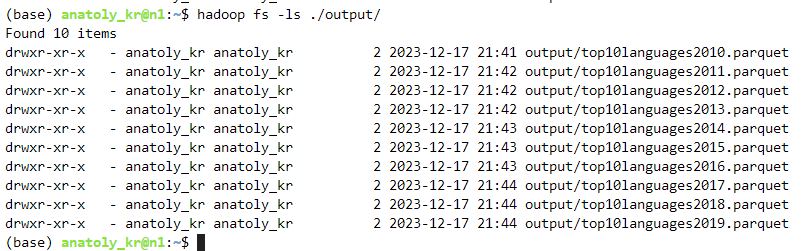